In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from lifelines import KaplanMeierFitter, CoxPHFitter
import tqdm
from models import create_compound_model_from_info, create_pytorch_model_from_info, MultiHead
import json
from misc import download_data_dir
import os

In [101]:
dropbox_url = 'https://www.dropbox.com/scl/fo/0zbnyynf5igdorbh6veqh/AE8PiJDZ5FB2Qbu_KiAF9W4?rlkey=km43xr7dpfssgdjcbev21ddb2&dl=1'
download_data_dir(dropbox_url, save_dir='/app/model_data')

In [3]:
dropbox_url = 'https://www.dropbox.com/scl/fo/y36aiinfbsf6rymzj1qh4/ACjkhRE_Ig_IBwlrH4Tl_Ug?rlkey=4s5imazvcoktgk83lig8rypjw&dl=1'
download_data_dir(dropbox_url, save_dir='/app/finetune_data')

In [4]:
# generalized function to run grid search with custom objective
def prep_surv_y(survival_column, event_column):
    """
    Function for formatting survival data as input to sksurv models.
    Args:
        survival_column: list of survival times
        event_column: list of event indicators (0 for censored, 1 for event)
    """
    surv_y = np.array([(event_column.iloc[i], survival_column.iloc[i]) for i in range(len(survival_column))], dtype=[('status', bool), ('time', float)])
    # surv_y = np.array([(event_column[i], survival_column[i]) for i in range(len(survival_column))], dtype=[('status', bool), ('time', float)])
    return surv_y

def create_data_dict(data_dir,set_name,os_col,event_col,data_dict=None):
    if data_dict is None:
        data_dict = {}
    X_path = f'{data_dir}/X_finetune_{set_name}.csv'
    y_path = f'{data_dir}/y_finetune_{set_name}.csv'
    X = pd.read_csv(X_path, index_col=0)
    y = pd.read_csv(y_path, index_col=0)
    not_nan = ~y[os_col].isna()
    data_dict[set_name] = {"X": X.loc[not_nan],
                           "y": prep_surv_y(y.loc[not_nan,os_col], y.loc[not_nan,event_col]),
                           'os_col':os_col,
                           'event_col':event_col,
                           'X_file':X_path,
                           'y_file':y_path}
    return data_dict

In [5]:
def get_best_cph_threshold(model_trained, new_data):
    """
    Identify the threshold that maximizes C-index between classes where p remains significant. Note: this does NOT account for clinical covariates
    Args:
        model_trained: trained CoxPH model
        new_data: dict with new data (transformed and scaled) and survival data
        feats: list of features to use
    Returns:
        dictionary with p-value, coefficient, concordance index, and number of samples in each class
    """

    tmp = pd.DataFrame(new_data["y"]).set_axis(['Event', 'Survival'], axis=1)

    # predict survival
    # if type(model_trained) == xgb.core.Booster:
    #     predicted_surv = model_trained.predict(new_data["xgb_x"])
    # else: 
    predicted_surv = model_trained.predict(new_data["X"].to_numpy())

    # identify threshold maximizing c-index between classes where p remains significant
    thresh_summary = {}
    for th in np.unique(predicted_surv):
        # predict classes
        pred_ev = (predicted_surv > th)
        mod_d = tmp.copy()
        mod_d['pred'] = pred_ev

        if any(mod_d['pred']) & any(~mod_d['pred']):  # only look if there's at least 1 of both classes

            try:
                cph = CoxPHFitter()
                cph.fit(mod_d, 'Survival', 'Event', formula='pred')
                thresh_summary[th] = {'p': cph.summary.loc['pred']['p'], 'coef': cph.summary.loc['pred']['coef'], 'c_ind': cph.concordance_index_, "n_lo": sum(pred_ev==0), "n_hi": sum(pred_ev==1)}
            except:
                thresh_summary[th] = {'p': np.nan, 'coef': np.nan, 'c_ind': np.nan, "n_lo": sum(pred_ev==0), "n_hi": sum(pred_ev==1)}

            # calculate median survival of each class
            kmf = KaplanMeierFitter()
            for i in [False, True]:
                lab_map = {True: "lo", False: "hi"}
                kmf.fit(mod_d.loc[mod_d['pred']==i, 'Survival'], mod_d.loc[mod_d['pred']==i, 'Event'], label=f"class_{i}")
                thresh_summary[th][f"io_{lab_map[i]}_mst"] = kmf.median_survival_time_

    thresh_df = pd.DataFrame(thresh_summary).T
    thresh_df = thresh_df.loc[thresh_df['io_hi_mst'] > thresh_df['io_lo_mst']].dropna()  # drop any where hi class has lower median survival
    if any(thresh_df['p']<0.05):
        best_thresh = thresh_df.loc[thresh_df['p']<0.05].sort_values('c_ind', ascending=False).iloc[0].name
    else:
        best_thresh = 0
    return best_thresh

In [6]:
def get_best_3way_threshold(model_trained, new_data,min_class_size=20):
    """
    Identify the threshold that maximizes C-index between classes where p remains significant. 
    Note: this does NOT account for clinical covariates
    Further note: sksurv models with LOWER predicted survival are associated with LONGER survival
    Args:
        model_trained: trained CoxPH model
        new_data: dict with new data (transformed and scaled) and survival data
    Returns:
        optimal thresholds as a tuple. 
          To apply these thresholds downstream, predicted survival of  "FAVORABLE" <= the LOWER threshold; "INTERMEDIATE" > LOWER and <= HIGHER; "POOR" > HIGHER
    """


    best_thresh = (np.nan, np.nan)

    tmp = pd.DataFrame(new_data["y"]).set_axis(['Event', 'Survival'], axis=1)

    predicted_surv = model_trained.predict(new_data["X"].to_numpy()).flatten()

    thresh_list = np.sort(np.unique(predicted_surv))  # SUBSET FOR DEV
    # identify threshold maximizing c-index between classes where p remains significant
    thresh_summary = {}
    for th_lo in tqdm.tqdm(thresh_list):
        for th_hi in thresh_list[thresh_list>th_lo]:
            # predict classes
            pred_class = np.empty_like(predicted_surv, dtype=object)
            pred_class[predicted_surv <= th_lo] = 'FAVORABLE'
            pred_class[(predicted_surv > th_lo) & (predicted_surv <= th_hi)] = 'INTERMEDIATE'
            pred_class[predicted_surv > th_hi] = 'POOR'
            mod_d = tmp.copy()
            mod_d['pred'] = pred_class


            # don't bother unless we have >1 of each class
            if (sum(pred_class=='FAVORABLE')>min_class_size) & (sum(pred_class=='INTERMEDIATE')>min_class_size) & (sum(pred_class=='POOR')>min_class_size):
                thresh_summary[(th_lo, th_hi)] = {}
                # calculate median survival of each class
                kmf = KaplanMeierFitter()
                for i in mod_d['pred'].unique():
                    kmf.fit(mod_d.loc[mod_d['pred']==i, 'Survival'], mod_d.loc[mod_d['pred']==i, 'Event'])
                    thresh_summary[(th_lo, th_hi)][f"{i}_mst"] = kmf.median_survival_time_

                # don't bother unless median survival times are properly ordered
                if thresh_summary[(th_lo, th_hi)]["POOR_mst"] < thresh_summary[(th_lo, th_hi)]["INTERMEDIATE_mst"] < thresh_summary[(th_lo, th_hi)]["FAVORABLE_mst"]:
                    try:
                        releveled = mod_d.copy()
                        releveled['pred'] = pd.Categorical(releveled['pred'], categories=['INTERMEDIATE', 'POOR', 'FAVORABLE'], ordered=True)
                        cph_relev = CoxPHFitter()
                        cph_relev.fit(releveled, 'Survival', 'Event', formula='pred', fit_options={'step_size': 0.5})
                        p_list = cph_relev.summary['p'].values
                        # don't bother unless POOR vs INTERMEDIATE and INTERMEDIATE vs FAVORABLE are both significant
                        if all([i<0.05 for i in p_list]):
                            thresh_summary[(th_lo, th_hi)].update({'p': p_list, 'c_ind': cph_relev.concordance_index_, "n_POOR": sum(pred_class=='POOR'), "n_INTERMEDIATE": sum(pred_class=='INTERMEDIATE'), "n_FAVORABLE": sum(pred_class=='FAVORABLE')})
                    except:
                        pass

    thresh_df = pd.DataFrame(thresh_summary).T.dropna()

    if len(thresh_df)>0:
        best_thresh = thresh_df.dropna().sort_values('c_ind', ascending=False).index[0]

    return best_thresh

In [102]:
input_dir = '/app/model_data'
data_dir = '/app/finetune_data'

# X_data_path = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/April_30_Finetune_Data/X_finetune_test.csv'
# y_data_path = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/April_30_Finetune_Data/y_finetune_test.csv'
# X_data = pd.read_csv(X_data_path,index_col=0)
# y_data = pd.read_csv(y_data_path,index_col=0)

In [8]:
data_dict =create_data_dict(data_dir,'trainval','OS','OS_Event')
data_dict =create_data_dict(data_dir,'test','OS','OS_Event',data_dict)

In [9]:
data_dict['trainval']['X'].shape

(592, 2736)

In [100]:
model_info

{'encoder': {'training': True,
  'goal': 'encode',
  'kind': 'VAE',
  'file_id': 'VAE',
  'latent_size': 118,
  'input_size': 2736,
  'hidden_size': 177,
  'num_hidden_layers': 2,
  'dropout_rate': 0.1,
  'activation': 'leaky_relu',
  'use_batch_norm': False,
  'act_on_latent_layer': False,
  'kl_weight': 1.0},
 'head': {'training': True,
  'goal': 'survival',
  'kind': 'Cox',
  'name': 'OS',
  'y_idx': [0, 1],
  'weight': 1,
  'input_size': 119,
  'output_size': 1,
  'architecture': {'hidden_size': 4,
   'num_hidden_layers': 1,
   'dropout_rate': 0,
   'activation': 'leakyrelu',
   'use_batch_norm': False,
   'num_classes': 1,
   'input_size': 119},
  'score_func_dict': {'Concordance Index': '<function Cox_Head.__init__.<locals>.<lambda> at 0x7fe635a048b0>'},
  'file_id': 'Cox_OS',
  'loss_reduction': 'mean'}}

In [104]:
# Load the trained model
# model_info = json.load(open(f'{input_dir}/VAE__Cox_OS_info.json'))
# model_state = torch.load(f'{input_dir}/VAE__Cox_OS_state.pt')

model_info = json.load(open(f'{input_dir}/Model_2925 info.json'))
model_state = torch.load(f'{input_dir}/Model_2925 state.pt')

model_trained = create_pytorch_model_from_info(model_info, model_state)


In [105]:
y_trainval = pd.read_csv(os.path.join(data_dir, 'y_finetune_trainval.csv'), index_col=0)
pred_trainval = model_trained.predict(data_dict['trainval']["X"].to_numpy()).flatten()

/app/mz_embed_engine/ml/models.py:1228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_vars = torch.tensor(other_vars, dtype=torch.float32)


In [106]:
y_trainval['predicted hazard'] = pred_trainval
y_trainval['predicted survival'] = -1*pred_trainval

In [107]:
score1_counts = y_trainval['MSKCC ORDINAL'].value_counts()
low_score1_th = score1_counts.loc[0.0]/score1_counts.sum()
intermediate_score1_th = score1_counts.loc[1.0]/score1_counts.sum() + low_score1_th

score2_counts = y_trainval['IMDC ORDINAL'].value_counts()
low_score2_th = score2_counts.loc[0.0]/score2_counts.sum()
intermediate_score2_th = score2_counts.loc[1.0]/score2_counts.sum() + low_score2_th

low_score_per = (low_score1_th + low_score2_th + 1)/5 + 0.01
intermediate_score_per = (intermediate_score1_th + intermediate_score2_th + 2)/5


y_trainval['PROG-2925'] = 'NA'
low_score_th = np.percentile(y_trainval['predicted survival'], low_score_per*100)
intermediate_score_th = np.percentile(y_trainval['predicted survival'], intermediate_score_per*100)
y_trainval.loc[y_trainval['predicted survival'] <= low_score_th, 'PROG-2925'] = 'POOR'
y_trainval.loc[(y_trainval['predicted survival'] > low_score_th) & (y_trainval['predicted survival'] <= intermediate_score_th), 'PROG-2925'] = 'INTERMEDIATE'
y_trainval.loc[y_trainval['predicted survival'] > intermediate_score_th, 'PROG-2925'] = 'FAVORABLE'

y_trainval['PROG-2925'].value_counts().sort_index()

PROG-2925
FAVORABLE       178
INTERMEDIATE    242
POOR            172
Name: count, dtype: int64

In [108]:
print('low score threshold:', low_score_th)
print('intermediate score threshold:', intermediate_score_th)

low score threshold: -1.5716057490546005
intermediate score threshold: 6.461545399579221


In [109]:
y_trainval['PROG-2925'].value_counts()/y_trainval['PROG-2925'].value_counts().sum()

PROG-2925
INTERMEDIATE    0.408784
FAVORABLE       0.300676
POOR            0.290541
Name: count, dtype: float64

In [110]:
y_trainval['MSKCC'].value_counts().sort_index()/y_trainval['MSKCC'].value_counts().sum()

MSKCC
FAVORABLE       0.344595
INTERMEDIATE    0.472973
POOR            0.182432
Name: count, dtype: float64

In [111]:
y_trainval['IMDC'].value_counts().sort_index()/y_trainval['IMDC'].value_counts().sum()

IMDC
FAVORABLE       0.153716
INTERMEDIATE    0.596284
NOT REPORTED    0.038851
POOR            0.211149
Name: count, dtype: float64

In [112]:
y_test = pd.read_csv(os.path.join(data_dir, 'y_finetune_test.csv'), index_col=0)
pred_test = model_trained.predict(data_dict['test']["X"].to_numpy()).flatten()

y_test['predicted hazard'] = pred_test
y_test['predicted survival'] = -1*pred_test

y_test.loc[y_test['predicted survival'] <= low_score_th, 'PROG-2925'] = 'POOR'
y_test.loc[(y_test['predicted survival'] > low_score_th) & (y_test['predicted survival'] <= intermediate_score_th), 'PROG-2925'] = 'INTERMEDIATE'
y_test.loc[y_test['predicted survival'] > intermediate_score_th, 'PROG-2925'] = 'FAVORABLE'

y_test['PROG-2925'].value_counts().sort_index()

/app/mz_embed_engine/ml/models.py:1228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_vars = torch.tensor(other_vars, dtype=torch.float32)


PROG-2925
FAVORABLE        20
INTERMEDIATE    107
POOR             22
Name: count, dtype: int64

In [113]:
y_test['MSKCC'].value_counts().sort_index()

MSKCC
FAVORABLE       53
INTERMEDIATE    65
POOR            31
Name: count, dtype: int64

In [114]:
y_test['IMDC'].value_counts().sort_index()

IMDC
FAVORABLE       23
INTERMEDIATE    86
NOT REPORTED     6
POOR            34
Name: count, dtype: int64

## Balanced Prognostic Marker

In [115]:
# score1_counts = y_trainval['MSKCC ORDINAL'].value_counts()
# low_score1_th = score1_counts.loc[0.0]/score1_counts.sum()
# intermediate_score1_th = score1_counts.loc[1.0]/score1_counts.sum() + low_score1_th

# score2_counts = y_trainval['IMDC ORDINAL'].value_counts()
# low_score2_th = score2_counts.loc[0.0]/score2_counts.sum()
# intermediate_score2_th = score2_counts.loc[1.0]/score2_counts.sum() + low_score2_th

low_score_per = 1/3
intermediate_score_per = 2/3

prog_name = 'PROG-2925B'

y_trainval[prog_name] = 'NA'
low_score_th = np.percentile(y_trainval['predicted survival'], low_score_per*100)
intermediate_score_th = np.percentile(y_trainval['predicted survival'], intermediate_score_per*100)
y_trainval.loc[y_trainval['predicted survival'] <= low_score_th, prog_name] = 'POOR'
y_trainval.loc[(y_trainval['predicted survival'] > low_score_th) & (y_trainval['predicted survival'] <= intermediate_score_th), prog_name] = 'INTERMEDIATE'
y_trainval.loc[y_trainval['predicted survival'] > intermediate_score_th, prog_name] = 'FAVORABLE'

y_trainval[prog_name].value_counts().sort_index()

PROG-2925B
FAVORABLE       197
INTERMEDIATE    197
POOR            198
Name: count, dtype: int64

In [116]:
y_test.loc[y_test['predicted survival'] <= low_score_th, prog_name] = 'POOR'
y_test.loc[(y_test['predicted survival'] > low_score_th) & (y_test['predicted survival'] <= intermediate_score_th), prog_name] = 'INTERMEDIATE'
y_test.loc[y_test['predicted survival'] > intermediate_score_th, prog_name] = 'FAVORABLE'

y_test[prog_name].value_counts().sort_index()

PROG-2925B
FAVORABLE       25
INTERMEDIATE    95
POOR            29
Name: count, dtype: int64

## Prognostic Marker most similar to IMDC

In [117]:
imdc_counts = y_test['IMDC'].value_counts().sort_index()
imdc_counts = imdc_counts[['FAVORABLE', 'INTERMEDIATE', 'POOR']].copy()

In [118]:
low_score_per = imdc_counts.loc['POOR']/imdc_counts.sum()
intermediate_score_per = imdc_counts.loc['INTERMEDIATE']/imdc_counts.sum() + low_score_per
prog_name = 'PROG-2925C'

y_test_imdc = y_test[y_test['IMDC ORDINAL'].notna()].copy()

y_test_imdc[prog_name] = 'NA'

low_score_th = np.percentile(y_test_imdc['predicted survival'], low_score_per*100)
intermediate_score_th = np.percentile(y_test_imdc['predicted survival'], intermediate_score_per*100)

In [119]:
y_test_imdc.loc[y_test['predicted survival'] <= low_score_th, prog_name] = 'POOR'
y_test_imdc.loc[(y_test['predicted survival'] > low_score_th) & (y_test_imdc['predicted survival'] <= intermediate_score_th), prog_name] = 'INTERMEDIATE'
y_test_imdc.loc[y_test['predicted survival'] > intermediate_score_th, prog_name] = 'FAVORABLE'

y_test_imdc[prog_name].value_counts().sort_index()

PROG-2925C
FAVORABLE       23
INTERMEDIATE    86
POOR            34
Name: count, dtype: int64

## Matt's 3-way survival

In [108]:
predicted_surv = model_trained.predict(data_dict['trainval']["X"].to_numpy()).flatten()

In [12]:
best_thresh = get_best_3way_threshold(model_trained, data_dict['trainval'] , min_class_size=100)

/app/mz_embed_engine/ml/models.py:1228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_vars = torch.tensor(other_vars, dtype=torch.float32)
  0%|          | 0/592 [00:00<?, ?it/s]

 17%|█▋        | 100/592 [00:28<02:07,  3.85it/s]/usr/local/lib/python3.9/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column pred[T.FAVORABLE] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'pred[T.FAVORABLE]'].var())
>>> print(df.loc[~events, 'pred[T.FAVORABLE]'].var())

A very low variance means that the column pred[T.FAVORABLE] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.376. This may imply non-unique solutio

In [40]:
preds = model_trained.predict(data_dict['trainval']['X'].to_numpy())
y_true = pd.DataFrame(data_dict['trainval']["y"]).set_axis(['Event', 'Survival'], axis=1)

/Users/jonaheaton/mz_embed_engine/ml/models.py:1222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_vars = torch.tensor(other_vars, dtype=torch.float32)


In [46]:
np.exp(-1*preds)

array([[1.15302311e-04],
       [3.90175381e-04],
       [9.70400078e+04],
       [1.23506975e+01],
       [3.82161204e-04],
       [3.63818748e-04],
       [4.73069611e+01],
       [2.96681508e-04],
       [6.44252396e+01],
       [1.58239622e+01],
       [2.28646845e-01],
       [4.12667480e+02],
       [2.33947695e-03],
       [4.44571190e+01],
       [5.47999167e-04],
       [5.64803779e-01],
       [1.27047133e-02],
       [5.03552188e+04],
       [1.90551320e-04],
       [1.90164715e-01],
       [7.84399235e-05],
       [6.27984339e-03],
       [2.19714474e-02],
       [2.53388203e+04],
       [1.44666666e-03],
       [7.04611477e-04],
       [1.23674312e-04],
       [2.61236835e+00],
       [1.29745703e+05],
       [3.08479565e+03],
       [8.74004811e-02],
       [5.55036962e-01],
       [4.14381982e+03],
       [2.89021075e-01],
       [6.72421157e-02],
       [6.34912699e-02],
       [6.50243281e+04],
       [1.63030338e+00],
       [2.63795801e+04],
       [4.87966156e+01],


In [80]:
y_true['Survival']

0       3.614000
1       3.909700
2      50.759754
3      31.047228
4       1.938400
         ...    
587    56.542094
588    45.963039
589    34.266940
590    19.318300
591    57.067762
Name: Survival, Length: 592, dtype: float64

<Axes: xlabel='Predicted Survival', ylabel='True Survival'>

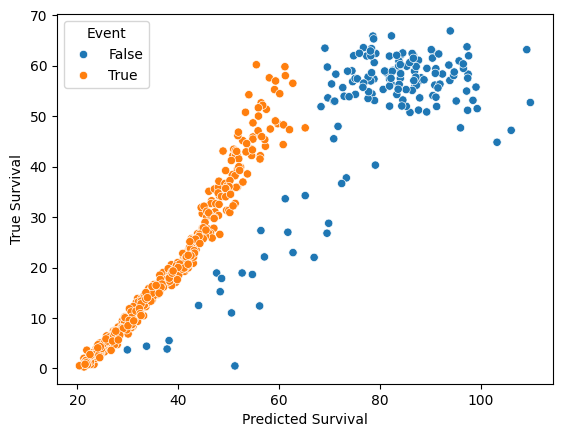

In [87]:
beta = 15
C = 40

df = pd.DataFrame({
    'Predicted Hazard': preds.flatten(),
    'Predicted Survival': C*np.exp(-1*preds/beta).flatten(),
    'True Survival': y_true['Survival'].values,
    'Event': y_true['Event'].values
})

# plt.scatter(C*np.exp(-1*preds/beta), y_true['Survival'], c=y_true['Event'])
sns.scatterplot(data=df, x='Predicted Survival', y='True Survival', hue='Event')
# plt.ylabel('Overall Survival')
# plt.xlabel('Predicted surival')
# plt.legend(
#     ['Event', 'Censored']
# )

<Axes: xlabel='Predicted Hazard', ylabel='True Survival'>

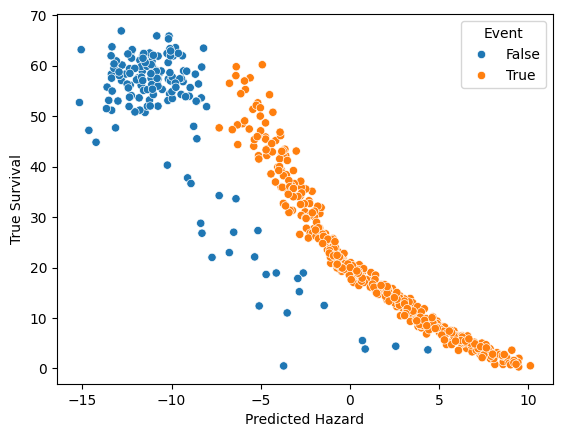

In [88]:
sns.scatterplot(data=df, x='Predicted Hazard', y='True Survival', hue='Event')

Text(0.5, 0, 'Predicted Hazard of TrainVal data')

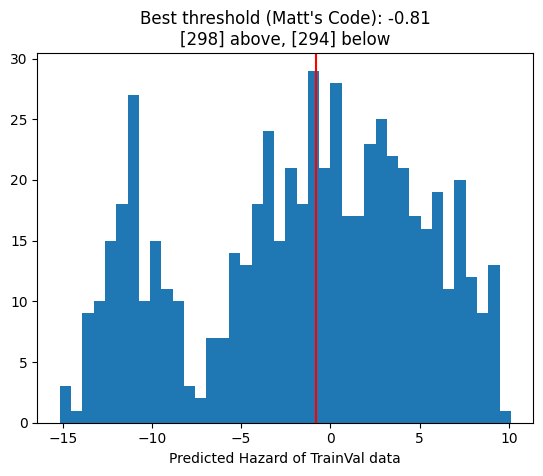

In [90]:
plt.hist(df['Predicted Hazard'], bins=40)
plt.axvline(best_th, color='r')
num_above = sum(preds>best_th)
num_below = sum(preds<=best_th)
plt.title(f"Best threshold (Matt's Code): {best_th:.2f}\n{num_above} above, {num_below} below")
plt.xlabel("Predicted Hazard of TrainVal data")

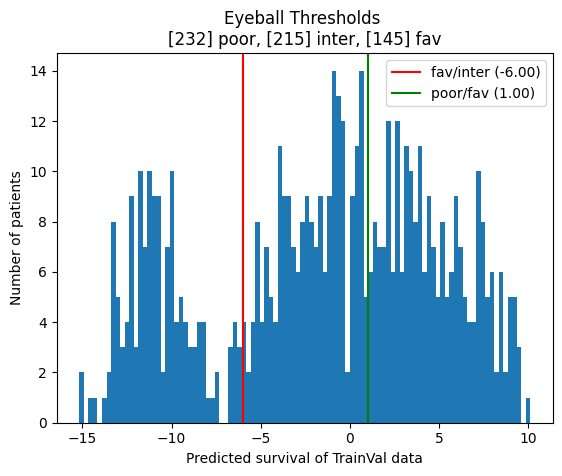

In [92]:
th1 = -6
th2 = 1
plt.hist(preds, bins=100)
plt.axvline(th1, color='r', label=f'fav/inter ({th1:.2f})')
plt.axvline(th2, color='g', label=f'poor/fav ({th2:.2f})')
num_fav = sum(preds<th1)
num_inter = sum((preds>=th1) & (preds<th2))
num_poor = sum(preds>=th2)
plt.title(f"Eyeball Thresholds \n{num_poor} poor, {num_inter} inter, {num_fav} fav")
plt.xlabel("Predicted survival of TrainVal data")
plt.ylabel("Number of patients")
plt.legend()

Text(0.5, 0, 'Predicted survival of Test data')

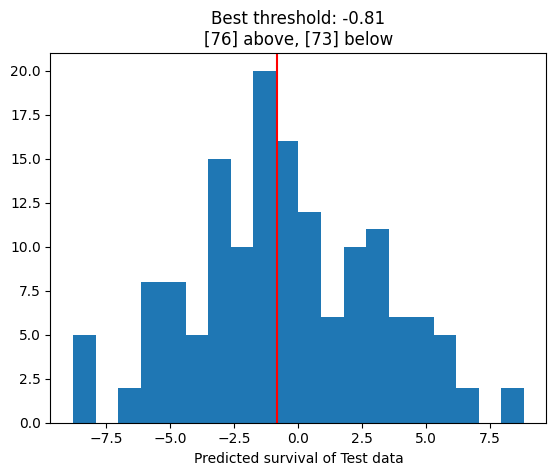

In [29]:
preds = model_trained.predict(data_dict['test']['X'].to_numpy())
plt.hist(preds, bins=20)
plt.axvline(best_th, color='r')
num_above = sum(preds>best_th)
num_below = sum(preds<=best_th)
plt.title(f"Best threshold: {best_th:.2f}\n{num_above} above, {num_below} below")
plt.xlabel("Predicted survival of Test data")



## KM comparison

In [120]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from lifelines.utils import restricted_mean_survival_time
from lifelines.statistics import logrank_test
import warnings
# from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import restricted_mean_survival_time


cmap = cm.get_cmap('Dark2')
# create a custom colormap with the 3rd color removed

k=3
reg_cmp = cm.get_cmap('tab10')
colors = cmap(np.arange(cmap.N))
colors = np.vstack((colors[0:k,:]))
newcmp = ListedColormap(colors, name=f'Dark2_{k}')



/tmp/ipykernel_1902539/2291163231.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Dark2')
/tmp/ipykernel_1902539/2291163231.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reg_cmp = cm.get_cmap('tab10')


In [84]:
y_test['OS']

,cohort_id,Study ID,Cohort Label,Cohort ID,OS,OS_Event,Age,subject ID,study_week,Region,...,IMDC BINARY,is Female,NIVO OS,EVER OS,NIVO PFS,EVER PFS,Treatment is NIVO,predicted hazard,predicted survival,PROG-2925
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0582_Marios_PD1_Inhib2_HP-EA003798-7.mzML,541,ST001237,adult_cancer,541,50.562628,0.0,62.0,CA209025-111-657,baseline,REST OF WORLD,...,1.0,1.0,NaN,50.562628,NaN,18.299795,0,-1.728422,1.728422,INTERMEDIATE
0293_Marios_PD1_Inhib2_HP-E9101785-7.mzML,541,ST001237,adult_cancer,541,24.607803,1.0,59.0,CA209025-33-12,baseline,WESTERN EUROPE,...,NaN,0.0,24.607803,NaN,1.905544,NaN,1,-0.746944,0.746944,INTERMEDIATE
0219_Marios_PD1_Inhib2_HP-EA003799-7.mzML,541,ST001237,adult_cancer,541,52.073922,0.0,66.0,CA209025-111-778,baseline,REST OF WORLD,...,NaN,0.0,52.073922,NaN,29.470226,NaN,1,1.085876,-1.085876,INTERMEDIATE
0962_Marios_PD1_Inhib2_HP-E9784758-7.mzML,541,ST001237,adult_cancer,541,24.246407,1.0,80.0,CA209025-180-1001,baseline,REST OF WORLD,...,0.0,1.0,NaN,24.246407,NaN,3.712526,0,-0.777657,0.777657,INTERMEDIATE
0218_Marios_PD1_Inhib2_HP-E9123067-7.mzML,541,ST001237,adult_cancer,541,3.614000,1.0,60.0,CA209025-113-50,baseline,WESTERN EUROPE,...,NaN,0.0,3.614000,NaN,2.759754,NaN,1,3.461896,-3.461896,POOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110_Marios_PD1_Inhib2_HP-AD827407-7.mzML,541,ST001237,adult_cancer,541,35.088300,1.0,63.0,CA209025-13-526,baseline,US/CANADA,...,NaN,0.0,NaN,35.088300,NaN,5.782341,0,-1.377524,1.377524,INTERMEDIATE
1105_Marios_PD1_Inhib2_HP-AE722161-7.mzML,541,ST001237,adult_cancer,541,55.490760,0.0,49.0,CA209025-185-805,baseline,US/CANADA,...,NaN,0.0,NaN,55.490760,NaN,13.141684,0,-5.360571,5.360571,FAVORABLE
0920_Marios_PD1_Inhib2_HP-AF003923-9.mzML,541,ST001237,adult_cancer,541,52.665298,0.0,46.0,CA209025-139-1006,baseline,US/CANADA,...,NaN,0.0,52.665298,NaN,2.069815,NaN,1,-2.635396,2.635396,INTERMEDIATE


OS col= OS
Cens col= OS_Event
Val col= PROG-2925C
length of data df 143


Text(0, 0.5, 'Survival probability')

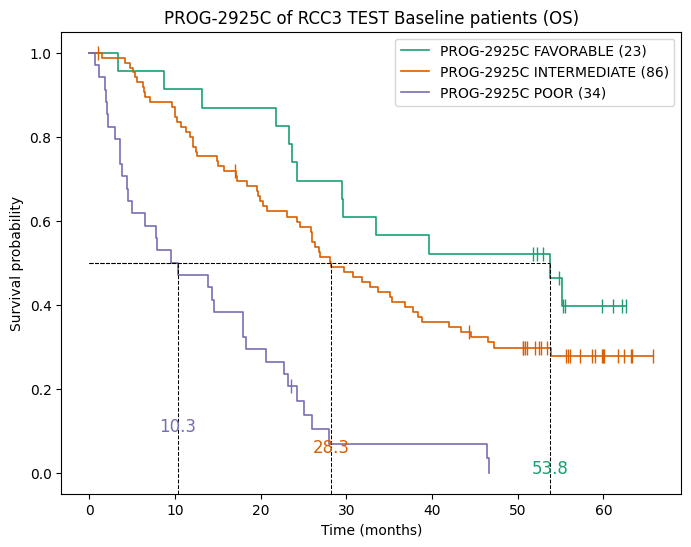

In [121]:
# y_data = y_test.copy()
y_data = y_test_imdc.copy()
# val_col = 'PROG-2925'
# val_col = 'PROG-2925B'
val_col = 'PROG-2925C'

# val_col = 'IMDC'

os_col = 'OS'
cens_col = 'OS_Event'

kmf = KaplanMeierFitter()

# print("clust_col=", clust_col)
print("OS col=", os_col)
print("Cens col=", cens_col)
print("Val col=", val_col)

out_dict = {}
fig = plt.figure(figsize=(8,6))

data_df = y_data[(y_data['Set']=='Test') & (~y_data[val_col].isna()) & (y_data[val_col]!='NOT REPORTED')].copy()
print("length of data df", len(data_df))

lnw = 0.75
median_survival_time_list =[]

os_list = []
cens_list = []


val_lvls = data_df[val_col].unique()
val_lvls = sorted(val_lvls,key=lambda x: x[0])
for i in val_lvls:
    df_s = data_df[data_df[val_col] == i].copy()
    os_vals = df_s[os_col]
    cens_vals = df_s[cens_col]
    #kmf.fit(os, event_observed=cens, label=f'NMF{k} Cluster {i}')
    #kmf.plot(ax=plt.gca(),show_censors=True,ci_show=False,linewidth=lnw)
    #median_survival_time_list.append(kmf.median_survival_time_)
    os_list.append(os_vals)
    cens_list.append(cens_vals)

for i,os_vals in enumerate(os_list):
    cens = cens_list[i]
    kmf.fit(os_vals, event_observed=cens, label=f'{val_col} {val_lvls[i]} ({len(os_vals)})')
    # kmf.fit(os_vals, event_observed=eval(f"os_cen{i+1}"), label=f'Cluster {i+1} ({len(os_vals)})')

    ax = kmf.plot(show_censors=True,ci_show=False,censor_styles={'marker':'|','ms':10},linewidth=1.2,color=newcmp(i))
    median_survival_time = kmf.median_survival_time_
    median_survival_time_list.append(median_survival_time)

prev_t = 0
for i,t in enumerate(median_survival_time_list):
    ax.hlines(0.5,0,t,linestyles='--',color='k',linewidth=lnw)
    ax.axvline(t,ymax=0.5,ls='--',color='k',linewidth=lnw)
    ax.text(t,0.01+i*0.05,f'{t:.1f}',rotation=0,va='center',ha='center',color=newcmp(i),fontsize=12)


out_dict['mst'] = dict(zip(data_df[val_col].dropna().unique(),median_survival_time_list))

plt.title(f'{val_col} of RCC3 TEST Baseline patients ({os_col})')
plt.ylim(-.05,1.05)
plt.xlabel('Time (months)')
plt.ylabel('Survival probability')


In [122]:
km_p_dict = {}
for clin_val in val_lvls:
    for clin_val2 in val_lvls:
        if clin_val != clin_val2:
            sub_d = y_data.loc[y_data[val_col].isin([clin_val, clin_val2])].copy()
            # perform logrank test against Treatment for each clin_val
            log_res = logrank_test(sub_d[sub_d[val_col]==clin_val][os_col], 
                                sub_d[sub_d[val_col]==clin_val2][os_col], 
                                sub_d[sub_d[val_col]==clin_val][cens_col], 
                                sub_d[sub_d[val_col]==clin_val2][cens_col])
            # print(log_res)
            print(sub_d.shape)
            km_p_dict[(clin_val, clin_val2)] = {"p": format(log_res.p_value, '.2e'), 
                                                "mst_1": out_dict["mst"][clin_val], 
                                                "mst_2": out_dict["mst"][clin_val2], 
                                                "mst_diff": 
                                                    out_dict["mst"][clin_val] - out_dict["mst"][clin_val2]}


# df of median survial times rounded to 1 decimal place with logrank p values
pd.DataFrame.from_dict(km_p_dict, orient="index").round(3).sort_index()

(109, 55)
(57, 55)
(109, 55)
(120, 55)
(57, 55)
(120, 55)


p   mst_1   mst_2  mst_diff
FAVORABLE    INTERMEDIATE  1.23e-01  10.349  53.815   -43.466
             POOR          1.60e-07  10.349  28.255   -17.906
INTERMEDIATE FAVORABLE     1.23e-01  53.815  10.349    43.466
             POOR          1.26e-08  53.815  28.255    25.561
POOR         FAVORABLE     1.60e-07  28.255  10.349    17.906
             INTERMEDIATE  1.26e-08  28.255  53.815   -25.561

In [88]:
import lifelines

In [90]:
sub_d.shape

(120, 53)

In [89]:
lifelines.__version__

'0.28.0'